## Basic Setup

In [220]:
%pip install wandb
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

wandb.login()

class FetchedResults:
    def __init__(self, n_docs, n_queries):
        self.n_docs = n_docs
        self.n_queries = n_queries
        self.fetch()
    def fetch(self):
        artifact_name = f'retrieval_test_{self.n_docs}_{self.n_queries}'
        table = wandb.Api().artifact(f'tribler/retrieval-{self.n_docs}/{artifact_name}:latest').get(artifact_name)
        df = pd.DataFrame(data=table.data, columns=[col for col in table.columns])
        self.test_cases = df.groupby(['test_input', 'test_output'])
        self.valid_outputs = df['test_output'].unique()
    def accuracy(self, k=1):
        matches = self.test_cases.apply(lambda group: group['test_output'].iloc[0] == group.head(k)['output']).sum()
        acc = matches / float(self.test_cases.ngroups)
        return acc if acc <= 1 else 1
    def accuracy_on_valids(self, k=1):
        def accuracy_rate(group):
            filtered_group = group[group['output'].isin(self.valid_outputs)]
            return group['test_output'].iloc[0] == filtered_group.head(k)['output']
        matches = self.test_cases.apply(accuracy_rate).sum()
        acc = matches / float(self.test_cases.ngroups)
        return acc if acc <= 1 else 1
    def duplicates(self, k=1):
        def duplicate_rate(group):
            top_k = group.head(k)
            duplicates_count = top_k.duplicated(subset=['output'], keep=False).sum()
            rate = duplicates_count / len(top_k) if len(top_k) > 0 else 0
            return rate
        return self.test_cases.apply(duplicate_rate).mean()
    def invalids(self, k=1):
        def invalid_rate(group):
            top_k = group.head(k)
            invalid_count = (~top_k['output'].isin(self.valid_outputs)).sum()
            rate = invalid_count / len(top_k) if len(top_k) > 0 else 0
            return rate
        return self.test_cases.apply(invalid_rate).mean()

n_docs_exps = [100, 500, 1000]
n_queries_exps = range(1, 21)
exp_results = {n_docs: {n_queries: FetchedResults(n_docs, n_queries) for n_queries in n_queries_exps} for n_docs in n_docs_exps}

Note: you may need to restart the kernel to use updated packages.


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo

## Plot: Accuracy over Number of Queries and Documents

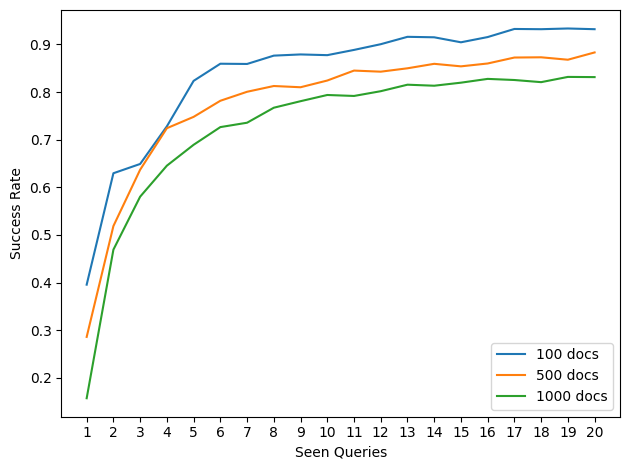

In [198]:
fig, ax = plt.subplots()

for n_docs in n_docs_exps:
    ax.plot(
        list(n_queries_exps),
        [exp_results[n_docs][n_queries].accuracy() for n_queries in n_queries_exps],
        label=f'{n_docs} docs'
    )

ax.set_xlabel("Seen Queries")
ax.set_ylabel("Success Rate")
ax.legend(loc='lower right', ncol=1)
plt.xticks(range(1, 20 + 1))
fig.tight_layout()
plt.show()

### Export as TikZ/TeX

In [43]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

tikzplotlib_fix_ncols(fig)

tikzplotlib.save("../plots/retrieval_accs.tex", axis_width=r'\columnwidth', axis_height=r'6cm')

<Figure size 640x480 with 0 Axes>

## Table: Top-k Accuracies and Hallucinations

In [221]:
interested_queries = [1, 2, 3, 4, 5, 10, 20]

rows = []

# Iterate through the precomputed results to populate the DataFrame rows
for n_docs, queries_dict in exp_results.items():
    for n_queries, result in queries_dict.items():
        if n_queries in interested_queries:
            # Construct a row for each document-query combination
            row = {
                "Documents": n_docs,
                "Queries": n_queries,
                
                "acc@top1": result.accuracy(k=1),
                "acc@top3": result.accuracy(k=3),
                "acc@top5": result.accuracy(k=5),
                "acc@top10": result.accuracy(k=10),
                
                "inv@top1": result.invalids(k=1),
                "inv@top3": result.invalids(k=3),
                "inv@top5": result.invalids(k=5),
                "inv@top10": result.invalids(k=10),
                
                "dup@top10": result.duplicates(k=10),
                "acc@top1valid": result.accuracy_on_valids(k=1),
            }
            rows.append(row)

df = pd.DataFrame(rows)
df

,Documents,Queries,acc@top1,acc@top3,acc@top5,acc@top10,inv@top1,inv@top3,inv@top5,inv@top10,dup@top10,acc@top1valid
0,100,1,0.39550,0.45700,0.48300,0.50750,0.21850,0.534833,0.64170,0.767950,0.000500,0.42650
1,100,2,0.62950,0.72300,0.75250,0.79200,0.03650,0.305333,0.40250,0.547300,0.002000,0.63550
2,100,3,0.64900,0.74900,0.79200,0.86450,0.01800,0.200833,0.26550,0.379550,0.015100,0.64950
3,100,4,0.72800,0.82500,0.87850,0.95350,0.00150,0.137333,0.20590,0.327200,0.014850,0.72850
4,100,5,0.82350,0.89800,0.93650,1.00000,0.00150,0.225500,0.30700,0.440650,0.020900,0.82400
5,100,10,0.87750,1.00000,1.00000,1.00000,0.00200,0.227833,0.34310,0.488500,0.143700,0.87800
6,100,20,0.93200,1.00000,1.00000,1.00000,0.00150,0.327833,0.43910,0.564600,0.057350,0.93200
7,500,1,0.28580,0.33870,0.36020,0.38630,0.29870,0.540967,0.62492,0.728460,0.001340,0.31430
8,500,2,0.51860,0.59850,0.63040,0.66720,0.02400,0.177900,0.25060,0.367910,0.000840,0.52100
9,500,3,0.63690,0.74430,0.80220,0.89020,0.01030,0.175733,0.24458,0.354250,0.022340,0.63850


### Export as TeX

In [222]:
with open('../tables/topk_accs_and_hallus.tex', 'w') as file:
    file.write(df.to_latex(index=False))

/var/folders/fz/h_r0ypg14n9ck7sr91hf8ntm0000gn/T/ipykernel_91914/3912603319.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(index=False)


'\\begin{tabular}{rrrrrrrrrrrr}\n\\toprule\n Documents &  Queries &  acc@top1 &  acc@top3 &  acc@top5 &  acc@top10 &  inv@top1 &  inv@top3 &  inv@top5 &  inv@top10 &  dup@top10 &  acc@top1valid \\\\\n\\midrule\n       100 &        1 &   0.39550 &   0.45700 &   0.48300 &    0.50750 &   0.21850 &  0.534833 &   0.64170 &   0.767950 &   0.000500 &        0.42650 \\\\\n       100 &        2 &   0.62950 &   0.72300 &   0.75250 &    0.79200 &   0.03650 &  0.305333 &   0.40250 &   0.547300 &   0.002000 &        0.63550 \\\\\n       100 &        3 &   0.64900 &   0.74900 &   0.79200 &    0.86450 &   0.01800 &  0.200833 &   0.26550 &   0.379550 &   0.015100 &        0.64950 \\\\\n       100 &        4 &   0.72800 &   0.82500 &   0.87850 &    0.95350 &   0.00150 &  0.137333 &   0.20590 &   0.327200 &   0.014850 &        0.72850 \\\\\n       100 &        5 &   0.82350 &   0.89800 &   0.93650 &    1.00000 &   0.00150 &  0.225500 &   0.30700 &   0.440650 &   0.020900 &        0.82400 \\\\\n       10